# Grid Encoding Model 2:
This model uses the fields themselves as covariates to predict point wise firing rate or spikes
dev. 10/29/2020

Imports

In [5]:
%matplotlib inline

import sys
import warnings
import traceback

from pathlib import Path
import pickle
from types import SimpleNamespace
from joblib import delayed, Parallel
from importlib import reload


import numpy as np
import pandas as pd
import scipy.signal as signal
import scipy.stats as stats
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual
sns.set(style='whitegrid', palette='muted')

import TreeMazeAnalyses2.Utils.robust_stats as rs
from TreeMazeAnalyses2.Analyses.subject_info import SubjectInfo, SubjectSessionInfo
from TreeMazeAnalyses2.Analyses import spatial_functions as spatial_funcs
import TreeMazeAnalyses2.Analyses.open_field_functions as of_funcs


In [3]:
rs = reload(rs)
spatial_funcs = reload(spatial_funcs)
of_funcs = reload(of_funcs)

Select subject to have some data to play with

In [3]:
data_path = Path('/home/alexgonzalez/Documents/data/butler_hardcastle')
file_name = 'grid_cell_data.pickle'

# load data
with (data_path / file_name).open('rb') as f:
    data = pickle.load(f)

# load info table
file_name = 'grid_cell_info_table.csv'
unit_info_table = pd.read_csv( (data_path / file_name) )

n_sessions = unit_info_table['sessions_id'].max()
n_units = unit_info_table.shape[0]
print(f"Number of sessions {n_sessions}")
print(f"Number of units {n_units}")

Number of sessions 48
Number of units 94


In [5]:
print(unit_info_table.head())

   units  sessions_id  session_units_id   subjects       dates     times  \
0      1            1                 0  Harlan 18  2017-07-12  10-42-40   
1      2            2                 0  Harlan 18  2017-07-17  14-42-42   
2      3            3                 0  Harlan 18  2017-07-20  09-57-33   
3      4            3                 1  Harlan 18  2017-07-20  09-57-33   
4      5            4                 0  Harlan 18  2017-07-24  14-58-31   

  channels             sessions                   grid_cells_file_ids  
0    TT2c1  2017-07-12_10-42-40   Harlan 18_2017-07-12_10-42-40_TT2c1  
1    TT2c2  2017-07-17_14-42-42   Harlan 18_2017-07-17_14-42-42_TT2c2  
2    TT8c1  2017-07-20_09-57-33   Harlan 18_2017-07-20_09-57-33_TT8c1  
3   TT10c4  2017-07-20_09-57-33  Harlan 18_2017-07-20_09-57-33_TT10c4  
4    TT7c2  2017-07-24_14-58-31   Harlan 18_2017-07-24_14-58-31_TT7c2  


In [5]:
data.keys()

dict_keys(['behav_ts', 'behav_maps', 'neural_maps', 'spikes', 'fr'])

In [6]:
def plot_map(map_, ax=None):
    if ax is None:
        f, ax = plt.subplots()
    ax = sns.heatmap(map_, ax=ax)
    ax.invert_yaxis()
    ax.axis('equal')
    return ax.figure, ax
    

@interact(session_id=(0,n_sessions-1), neuron_id=widgets.IntSlider(min=0, max=5, step=1, value=0))
def _maps(session_id, neuron_id):
    
    n_session_neurons = data['neural_maps'][session_id].shape[0]
    print(f'num neurons = {n_session_neurons}')
    if neuron_id < n_session_neurons:
        fr_map = data['neural_maps'][session_id][neuron_id]
        f,ax = plt.subplots(figsize=(7,6))
        plot_map(fr_map, ax=ax)
        ax.set_title('Rate Map')

interactive(children=(IntSlider(value=23, description='session_id', max=47), IntSlider(value=0, description='n…

## try computing grid score

In [62]:
gs = np.zeros(n_units)*np.nan
scale = np.zeros(n_units)*np.nan
phase = np.zeros(n_units)*np.nan

for unit in range(n_units):
    try:
        session_id = unit_info_table.loc[unit,'sessions_id']-1
        unit_id = unit_info_table.loc[unit,'session_units_id']
        fr_map = data['neural_maps'][session_id][unit_id]
        fr_map = fr_map/fr_map.max()
        
        gs[unit], scale[unit], phase[unit],_ = spatial_funcs.compute_grid_score(fr_map, non_linearity=1)
    except:
        pass

gs_unit_ids = np.where(~np.isnan(gs))[0]
non_gs_unit_ids = np.where(np.isnan(gs))[0]
print(f'Number of units with sufficient autocorrelation fields {len(gs_unit_ids)}, or {len(gs_unit_ids)/n_units*100:0.2f}%  ' )
print(f'Valid Grid computation units: {gs_unit_ids}')

Number of units with sufficient autocorrelation fields 53, or 56.38%  
Valid Grid computation units: [ 2  3  4  6  9 10 11 12 14 16 19 20 22 23 25 26 27 30 34 35 36 40 42 44
 45 46 47 52 55 56 58 59 61 62 63 65 66 67 68 72 73 75 76 78 80 82 83 84
 85 86 88 90 93]


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


## Apply sigmoid non-linearity to rate maps to increase field detection in auto correlations

In [8]:
@interact_manual(unit=(0,n_units-1), 
          c=widgets.FloatSlider(min=0,max=1,step=0.01,value=0.4),
          sl=widgets.FloatSlider(min=0,max=30,step=0.1,value=20))
def _maps2(unit, c, sl):
    session_id = unit_info_table.loc[unit,'sessions_id']-1
    unit_id = unit_info_table.loc[unit,'session_units_id']
    n_session_neurons = data['neural_maps'][session_id].shape[0]
    
    print(f'Session id:  {session_id}; Unit {unit_id}')
    print(unit_info_table.at[unit,'grid_cells_file_ids']) 
    
    fr_map = data['neural_maps'][session_id][unit_id]
    fr_map_max = fr_map.max()
    fr_map = fr_map/fr_map_max
    fr_map_mean = np.mean(fr_map)
    fr_map_var = np.var(fr_map)
    print(f'mFR={fr_map_mean:0.2f}; vFR={fr_map_var:0.2f}')
    
    print('Original Scores')
    gs, scale, phase,_ = spatial_funcs.compute_grid_score(fr_map, non_linearity=1, radix_rel_range=[0.5, 2.5])
    print(f'gs={gs:0.2f}; scale={scale:0.2f}')
    
    f,ax = plt.subplots(2,3,figsize=(18,10))
    ax = ax.flatten()
    
    x = data['behav_ts'][session_id]['x']
    y = data['behav_ts'][session_id]['y']
    spk = data['spikes'][session_id][unit_id]
    ax[0].plot(x,y,linewidth=0.5,color='0.8', zorder=0)
    ax[0].scatter(x,y,spk*5, color='r',zorder=10)
    ax[0].axis('off')
    
    plot_map( fr_map , ax=ax[1])
    ax[1].set_title('Rate Map')
    
    #a1 = rs.compute_autocorr_2d(fr_map)
    a1 = signal.correlate2d(fr_map,fr_map, boundary='wrap')
    a1 = a1/a1.max()
    
    plot_map( a1 , ax=ax[2])
    ax[2].set_title('AutoCorr Map')
    
    xx = np.linspace(0,1,100)
    yy = spatial_funcs.sigmoid(xx,c,sl)
    ax[3].plot(xx,yy,linewidth=3)
    ax[3].axvline(c, linestyle='--', color='b')
    ax[3].axvline(fr_map_mean, linestyle='--', color='r')
    ax[3].set_xlabel('Normalized FR')
    ax[3].set_ylabel('Transformed Rate')
    
    fr_map2 = spatial_funcs.sigmoid(fr_map,c,sl)
    fr_map2 = fr_map2/fr_map2.max()
    plot_map( fr_map2 , ax=ax[4])
    ax[4].set_title('NL - Rate Map')
    
    a2 = signal.correlate2d(fr_map2,fr_map2, boundary='wrap')
    a2 = a2/a2.max()
    
    plot_map(a2 , ax=ax[5])
    ax[5].set_title('NL - AutoCorr Map')
    
    print('NL Scores')
    gs, scale, phase,_ = spatial_funcs.compute_grid_score(fr_map2, non_linearity=1, radix_rel_range=[0.5, 2.5])
    print(f'gs={gs:0.2f}; scale={scale:0.2f}')
  

interactive(children=(IntSlider(value=46, description='unit', max=93), FloatSlider(value=0.4, description='c',…

### get grid scores for the units using non-linear approach

In [9]:
gs_nl = np.zeros(n_units)*np.nan
scale_nl = np.zeros(n_units)*np.nan
phase_nl = np.zeros(n_units)*np.nan

sigmoid_params = {'center':0.4, 'slope': 20}
for unit in range(n_units):
    try:
        session_id = unit_info_table.loc[unit,'sessions_id']-1
        unit_id = unit_info_table.loc[unit,'session_units_id']
        fr_map = data['neural_maps'][session_id][unit_id]
            
        map_mean = np.median(fr_map)
        map_var = np.var(fr_map)
        fr_map = fr_map/fr_map.max()
        fr_map = spatial_funcs.sigmoid(fr_map, **sigmoid_params) 
        gs_nl[unit], scale_nl[unit], phase_nl[unit],_ = spatial_funcs.compute_grid_score(fr_map, non_linearity=1)
    except:
        pass

gs_unit_ids = np.where(~np.isnan(gs_nl))[0]
non_gs_unit_ids = np.where(np.isnan(gs_nl))[0]
print(f'Number of units with sufficient autocorrelation fields {len(gs_unit_ids)}, or {len(gs_unit_ids)/n_units*100:0.2f}%  ' )
print(f'Valid Grid computation units: {gs_unit_ids}')

Number of units with sufficient autocorrelation fields 61, or 64.89%  
Valid Grid computation units: [ 2  3  6  7  9 10 11 12 14 15 17 20 22 23 24 25 26 30 31 32 33 34 35 36
 39 40 41 42 44 45 46 47 52 53 54 55 56 57 58 59 61 63 66 67 68 71 72 73
 76 78 79 81 82 83 84 85 86 87 88 90 93]


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


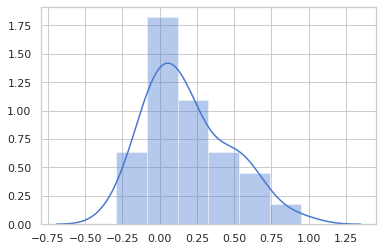

In [10]:
sns.distplot(gs)

## plot cells that gs was successful

In [11]:
@interact(unit=gs_unit_ids, 
          c=widgets.FloatSlider(min=0,max=1,step=0.01,value=0.4),
          sl=widgets.FloatSlider(min=0,max=30,step=0.1,value=20))

def _maps2(unit, c, sl):
    session_id = unit_info_table.loc[unit,'sessions_id']-1
    unit_id = unit_info_table.loc[unit,'session_units_id']
    n_session_neurons = data['neural_maps'][session_id].shape[0]
    
    print(f'Session id:  {session_id}; Unit {unit_id}')
    print(unit_info_table.at[unit,'grid_cells_file_ids'])
    print(f'GS={gs[unit]:0.2f} Scale={scale[unit]:0.2f} Phase={phase[unit]:0.2f}')
    
    fr_map = data['neural_maps'][session_id][unit_id]
    max_fr = fr_map.max()
    
    f,ax = plt.subplots(2,2,figsize=(12,10))
    ax = ax.flatten()
    
    n_fr_map = fr_map/max_fr
    plot_map( n_fr_map , ax=ax[0])
    ax[0].set_title(f'Rate Map Max={max_fr:0.2f}')

    sigmoid_params_ = {'center':c, 'slope': sl}
    nl_fr_map = spatial_funcs.sigmoid(n_fr_map, **sigmoid_params_) 
    plot_map(nl_fr_map , ax=ax[1])
    ax[1].set_title('NL - Rate Map')
    
    
    #a1 = rs.compute_autocorr_2d(n_fr_map)
    a1 = signal.correlate2d(n_fr_map,n_fr_map, boundary='wrap')
    plot_map(a1 , ax=ax[2])
    ax[2].set_title('Auto Corr')
    
    #a2 = rs.compute_autocorr_2d(nl_fr_map)
    a2 = signal.correlate2d(nl_fr_map,nl_fr_map, boundary='wrap')
    plot_map(a2 , ax=ax[3])
    ax[3].set_title('NL - Auto Corr')

interactive(children=(Dropdown(description='unit', options=(2, 3, 6, 7, 9, 10, 11, 12, 14, 15, 17, 20, 22, 23,…

## plot non grid cell

In [12]:
@interact(unit=non_gs_unit_ids, 
          c=widgets.FloatSlider(min=0,max=1,step=0.01,value=0.3),
          sl=widgets.FloatSlider(min=0,max=30,step=0.1,value=20))

def _maps2(unit, c, sl):
    session_id = unit_info_table.loc[unit,'sessions_id']-1
    unit_id = unit_info_table.loc[unit,'session_units_id']
    n_session_neurons = data['neural_maps'][session_id].shape[0]
    
    print(f'Session id:  {session_id}; Unit {unit_id}')
    print(unit_info_table.at[unit,'grid_cells_file_ids'])
    print(f'GS={gs[unit]:0.2f} Scale={scale[unit]:0.2f} Phase={phase[unit]:0.2f}')
    
    fr_map = data['neural_maps'][session_id][unit_id]
    max_fr = fr_map.max()

    f,ax = plt.subplots(2,2,figsize=(12,10))
    ax = ax.flatten()
    
    n_fr_map = fr_map/max_fr
    plot_map( n_fr_map , ax=ax[0])
    ax[0].set_title(f'Rate Map Max={max_fr:0.2f}')

    sigmoid_params_ = {'center':c, 'slope': sl}
    nl_fr_map = spatial_funcs.sigmoid(n_fr_map, **sigmoid_params_) 
    plot_map(nl_fr_map , ax=ax[1])
    ax[1].set_title('NL - Rate Map')
    
    
    a1 = rs.compute_autocorr_2d(n_fr_map)
    plot_map(a1 , ax=ax[2])
    ax[2].set_title('Auto Corr')
    
    a2 = rs.compute_autocorr_2d(nl_fr_map)
    plot_map(a2 , ax=ax[3])
    ax[3].set_title('NL - Auto Corr')

interactive(children=(Dropdown(description='unit', options=(0, 1, 4, 5, 8, 13, 16, 18, 19, 21, 27, 28, 29, 37,…

## Use field detection directly and then comput grid scores based on detected fields.

In [13]:
gs_fields = np.zeros(n_units)*np.nan
scale_fields = np.zeros(n_units)*np.nan
phase_fields = np.zeros(n_units)*np.nan

for unit in range(n_units):
    try:
        session_id = unit_info_table.loc[unit,'sessions_id']-1
        unit_id = unit_info_table.loc[unit,'session_units_id']
        
        fr_map = data['neural_maps'][session_id][unit_id]
        fr_map = fr_map/fr_map.max()
        fr_map_mean = fr_map.mean()
        
        fields_map, _ = spatial_funcs.get_map_fields(fr_map, fr_thr=fr_map_mean)
        thr_fr_map = (fields_map>=0)*fr_map
        
        gs_fields[unit], scale_fields[unit], phase_fields[unit],_ = spatial_funcs.compute_grid_score(thr_fr_map, non_linearity=1)
    except:
        pass

gs_fields_unit_ids = np.where(~np.isnan(gs_fields))[0]
non_gs_fields_unit_ids = np.where(np.isnan(gs_fields))[0]
print(f'Number of units with sufficient autocorrelation fields {len(gs_fields_unit_ids)}, or {len(gs_fields_unit_ids)/n_units*100:0.2f}%  ' )
print(f'Valid Grid computation units: {gs_fields_unit_ids}')

Number of units with sufficient autocorrelation fields 56, or 59.57%  
Valid Grid computation units: [ 0  2  3  4  6  9 11 12 14 15 16 18 19 20 22 23 24 25 26 27 30 34 35 36
 40 42 44 45 46 47 52 54 56 58 59 61 62 63 65 66 67 68 72 73 75 76 78 80
 82 83 84 85 86 88 90 93]


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [14]:
@interact(unit=(0,n_units-1))

def _maps2(unit):
    session_id = unit_info_table.loc[unit,'sessions_id']-1
    unit_id = unit_info_table.loc[unit,'session_units_id']
    n_session_neurons = data['neural_maps'][session_id].shape[0]
    
    print(f'Session id:  {session_id}; Unit {unit_id}')
    print(unit_info_table.at[unit,'grid_cells_file_ids'])
    
    print()
    print('NL - Scores')
    print(f'GS={gs[unit]:0.2f} Scale={scale[unit]:0.2f}')

    print()
    print('Thr Scores')
    print(f'GS={gs_fields[unit]:0.2f} Scale={scale_fields[unit]:0.2f}')
    
    fr_map = data['neural_maps'][session_id][unit_id]
    fr_map_max = fr_map.max()
    fr_map = fr_map/fr_map_max
    fr_map_mean = fr_map.mean()

    fields_map, _ = spatial_funcs.get_map_fields(fr_map, fr_thr=fr_map_mean)
    thr_fr_map = (fields_map>=0)*fr_map
    
    
    f,ax = plt.subplots(2,2,figsize=(12,10))
    ax = ax.flatten()
    
    plot_map(fr_map , ax=ax[0])
    ax[0].set_title(f'Rate Map Max={fr_map_max:0.2f}')

    plot_map(thr_fr_map , ax=ax[1])
    ax[1].set_title('Thr Rate Map')
    
    
    #a1 = rs.compute_autocorr_2d(fr_map)
    a1=signal.correlate2d(fr_map,fr_map,boundary='wrap')
    plot_map(a1 , ax=ax[2])
    ax[2].set_title('Auto Corr')
    
    #a2 = rs.compute_autocorr_2d(thr_fr_map)
    a2=signal.correlate2d(thr_fr_map,thr_fr_map,boundary='wrap')
    plot_map(a2 , ax=ax[3])
    ax[3].set_title('Thr Auto Corr')

interactive(children=(IntSlider(value=46, description='unit', max=93), Output()), _dom_classes=('widget-intera…

Text(0.5, 0, 'GS: Fields - NL ')

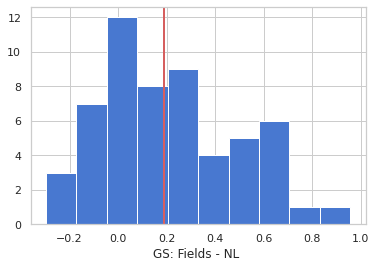

In [15]:
f,ax = plt.subplots()
ax.hist(gs_fields)
ax.axvline(np.nanmedian(gs_fields),color='r', linewidth=2)
ax.set_xlabel('GS: Fields - NL ')

### combination approach

In [323]:
spatial_funcs = reload(spatial_funcs)

gs_nl_fields = np.zeros(n_units)*np.nan
scale_nl_fields = np.zeros(n_units)*np.nan
phase_nl_fields = np.zeros(n_units)*np.nan

for unit in range(n_units):
    try:
        session_id = unit_info_table.loc[unit,'sessions_id']-1
        unit_id = unit_info_table.loc[unit,'session_units_id']
        
        fr_map = data['neural_maps'][session_id][unit_id]
        gs_nl_fields[unit], scale_nl_fields[unit], phase_nl_fields[unit],_ = spatial_funcs.compute_grid_score(fr_map)
#         fr_map_max = fr_map.max()
#         fr_map = fr_map/fr_map.max()
#         fr_map_mean = fr_map.mean()
        
#         fr_map = spatial_funcs.sigmoid(fr_map,**sigmoid_params)
        
#         fields_map, n_fields = spatial_funcs.get_map_fields(fr_map, fr_thr=fr_map_mean*0.5)
#         thr_fr_map = (fields_map>=0)*fr_map
    
#         if n_fields>=3:
#             gs_nl_fields[unit], scale_nl_fields[unit], phase_nl_fields[unit],_ = spatial_funcs.compute_grid_score(thr_fr_map, non_linearity=1)

    except:
        traceback.print_exc(file=sys.stdout)
        break
        #pass

gs_nl_fields_unit_ids = np.where(~np.isnan(gs_nl_fields))[0]
non_nl_gs_fields_unit_ids = np.where(np.isnan(gs_nl_fields))[0]
print(f'Number of units with sufficient autocorrelation fields {len(gs_nl_fields_unit_ids)}, or {len(gs_nl_fields_unit_ids)/n_units*100:0.2f}%  ' )
print(f'Valid Grid computation units: {gs_nl_fields_unit_ids}')

Did not find enough auto correlation fields.
Did not find enough auto correlation fields.
Did not find enough auto correlation fields.
Did not find enough auto correlation fields.
Did not find enough auto correlation fields.
Did not find enough auto correlation fields.
Not enought rate fields found to have a reliable computation.
Did not find enough auto correlation fields.
Not enought rate fields found to have a reliable computation.
Did not find enough auto correlation fields.
Did not find enough auto correlation fields.
Not enought rate fields found to have a reliable computation.
Not enought rate fields found to have a reliable computation.
Not enought rate fields found to have a reliable computation.
Not enought rate fields found to have a reliable computation.
Did not find enough auto correlation fields.
Did not find enough auto correlation fields.
Did not find enough auto correlation fields.
Not enought rate fields found to have a reliable computation.
Did not find enough auto c

In [317]:
unit

19

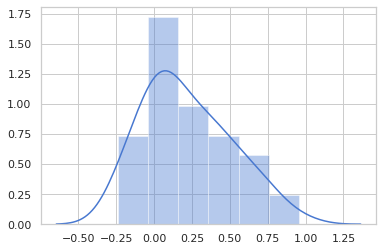

In [17]:
sns.distplot(gs_nl_fields)

In [18]:
gs_scores = pd.DataFrame(np.array([gs,gs_nl,gs_fields,gs_nl_fields]).T, columns=['gs','gs_nl', 'gs_fields', 'gs_nl_fields'])
gs_scales = pd.DataFrame(np.array([scale,scale_nl,scale_fields,scale_nl_fields]).T, columns=['scale','scale_nl', 'scale_fields', 'scale_nl_fields'])

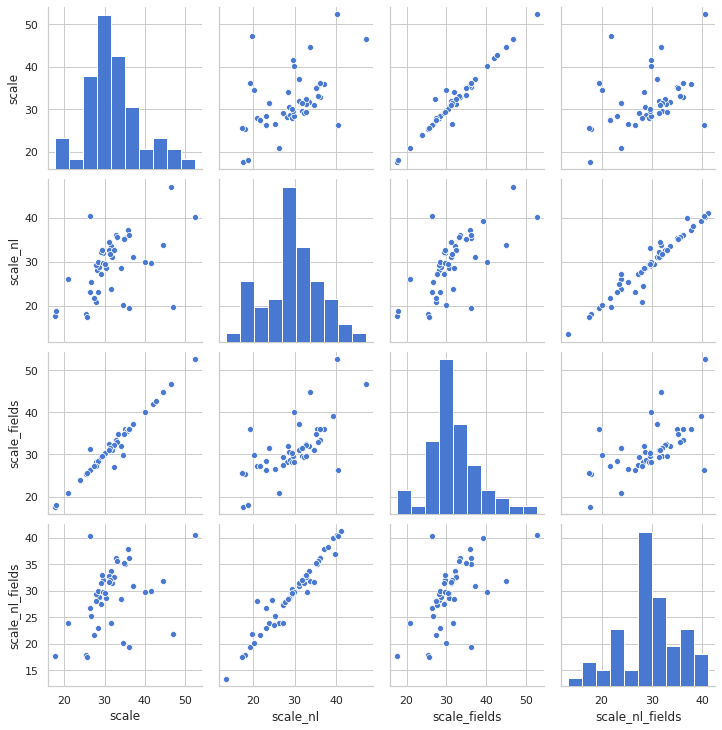

In [19]:
sns.pairplot(gs_scales)

In [20]:
print(f"all keys {list(data.keys())}")
print()
print(f"behavioral keys {list(data['behav_ts'][0].keys())}")
print()
print(f"spikes keys {list(data['spikes'].keys())}")


all keys ['behav_ts', 'behav_maps', 'neural_maps', 'spikes', 'fr']

behavioral keys ['x', 'y', 'ha', 'hd', 'speed']

spikes keys [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


# Grid encoding model

Original version uses a fitted moire grid based on the scale and phase of the computed autocorrelogram. Explore the effects of various parameters here.

Four versions: 
1. Linear with bias term
2. Linear w/o bias term
3. Poisson with bias term
4. Poisson w/o bias term

First. Obtain scale/phases and moire grids for each unit. For succesful Autocorrelations, scale and phases are computed from those estimates, otherwise fit a moire grid to obtain them.

In [21]:
spatial_funcs = reload(spatial_funcs)

height = 50
width = 50
# first get scales and phases based on fr map

moire_fits = np.zeros((n_units,height, width))
unit_grid_scales = np.zeros(n_units)
unit_grid_phases = np.zeros(n_units)
for unit in range(n_units):
    session_id = unit_info_table.loc[unit,'sessions_id']-1
    unit_id = unit_info_table.loc[unit,'session_units_id']
    
     # get data
    fr_map = data['neural_maps'][session_id][unit_id]

    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')

            if not np.isnan(scale_nl_fields[unit]):
                unit_grid_scales[unit] = scale_nl_fields[unit]
                unit_grid_phases[unit] = phase_nl_fields[unit]
                max_field_loc = np.unravel_index(np.argmax(fr_map), fr_map.shape)
                moire_fits[unit] = spatial_funcs.generate_moire_grid(width, height, [max_field_loc[1], max_field_loc[0]], 
                                                                     scale=unit_grid_scales[unit], theta=unit_grid_phases[unit])   
            else:
                temp = spatial_funcs.fit_moire_grid(fr_map)
                unit_grid_scales[unit] = temp[0]
                unit_grid_phases[unit] = temp[1]
                moire_fits[unit] = temp[2]
                
        print('.',end='')
    except:
        print(f'_{unit}',end='')
    


..............................................................................................

In [64]:
@interact(unit=(0,n_units-1))

def _maps2(unit):
    session_id = unit_info_table.loc[unit,'sessions_id']-1
    unit_id = unit_info_table.loc[unit,'session_units_id']
    
    print(f'Session id:  {session_id}; Unit {unit_id}')
    print(unit_info_table.at[unit,'grid_cells_file_ids'])
    print(f'Scale: {unit_grid_scales[unit]:0.2f}')
    
    f,ax = plt.subplots(2,2,figsize=(12,10))
    ax = ax.flatten()
    
    fr_map = data['neural_maps'][session_id][unit_id]
    fr_map_max = fr_map.max()
    fr_map = fr_map/fr_map_max

    fields_map, _ = spatial_funcs.get_map_fields(fr_map, fr_thr=fr_map_mean)
    thr_fr_map = (fields_map>=0)*fr_map
    
    plot_map(fr_map , ax=ax[0])
    ax[0].set_title(f'Rate Map Max={fr_map_max:0.2f}')
        
    plot_map(moire_fits[unit] , ax=ax[1])
    ax[1].set_title(f"Moire Grid")
    
    a2 = rs.compute_autocorr_2d(thr_fr_map)
    #a2=signal.correlate2d(thr_fr_map,thr_fr_map,boundary='wrap')    
    plot_map(a2 , ax=ax[2])
    ax[2].set_title(f"Auto Corr: RS")
    
    #a2 = rs.compute_autocorr_2d(thr_fr_map)
    a2=signal.correlate2d(thr_fr_map,thr_fr_map,boundary='wrap')    
    plot_map(a2 , ax=ax[3])
    ax[3].set_title(f"Auto Corr: Scipy")
    
    

interactive(children=(IntSlider(value=46, description='unit', max=93), Output()), _dom_classes=('widget-intera…

In [23]:
spatial_funcs = reload(spatial_funcs)

width = 50
height = 50
x_dim_cm = 150
y_dim_cm = 150

x_edges = np.linspace(0, x_dim_cm, width+1)
y_edges = np.linspace(0, y_dim_cm, height+1)

r2_scores = pd.DataFrame(index=range(n_units), columns=['linear', 'linear_bias', 'poisson', 'poisson_bias'])
map_corr = pd.DataFrame(index=range(n_units), columns=['linear', 'linear_bias', 'poisson', 'poisson_bias'])

options = {'linear': {'reg_type':'linear', 'bias_term': False},
           'linear_bias': {'reg_type':'linear', 'bias_term': True}, 
           'poisson': {'reg_type':'poisson', 'bias_term': False}, ## very poor perf.
           'poisson_bias': {'reg_type':'poisson', 'bias_term': True}}

for unit in range(n_units):
    session_id = unit_info_table.loc[unit,'sessions_id']-1
    unit_id = unit_info_table.loc[unit,'session_units_id']
    
     # get data
    x = data['behav_ts'][session_id]['x']
    y = data['behav_ts'][session_id]['y']
    spk = data['spikes'][session_id][unit_id]
    fr = data['fr'][session_id][unit_id]        
    fr_map = data['neural_maps'][session_id][unit_id]
    
    try:

        # normalize firing rate map (max=1)
        fr_map_max = fr_map.max()
        fr_map = fr_map/fr_map_max

        for opt, vals in options.items(): 
            if vals['reg_type']=='poisson':
                spk_hat, _, r2,_, _ = spatial_funcs.get_encoding_map_fit(spk,  moire_fits[unit], x, y, x_edges=x_edges, y_edges=y_edges, **vals)
                fr_map_hat = spatial_funcs.spikes_2_rate_map(spk_hat.flatten(), x, y, x_edges=x_edges, y_edges=y_edges)
            else:
                fr_hat, _, r2,_, _ = spatial_funcs.get_encoding_map_fit(fr,  moire_fits[unit], x, y, x_edges=x_edges, y_edges=y_edges, **vals)
                fr_map_hat = spatial_funcs.firing_rate_2_rate_map(fr_hat.flatten(), x, y, x_edges=x_edges, y_edges=y_edges)

            r2_scores.at[unit, opt] = r2
            map_corr.at[unit, opt] = rs.spearman(fr_map.flatten(), fr_map_hat.flatten())

        print('.',end='')

    except:
        print('_',end='')
        
r2_scores = r2_scores.astype(float)
map_corr = map_corr.astype(float)

r2_scores['unit'] = np.arange(n_units)
scores_df = r2_scores.melt(id_vars='unit',var_name='type', value_name='r2_score')

map_corr['unit'] = np.arange(n_units)
map_df = map_corr.melt(id_vars='unit',var_name='type', value_name='map_corr')

scores_df['map_corr'] = map_df['map_corr']

..

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


.

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: overflow encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)


.........

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


..

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


.....

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


..

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


.......

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


.

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: overflow encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)


.......

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


....

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: overflow encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)


.

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: overflow encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)


.

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: overflow encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)


..

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


....

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


..

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


.....

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: overflow encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)


...

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: overflow encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)


.

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


.

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


.

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: overflow encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)


.

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


...

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: overflow encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)


....._

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


...

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


.

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


.

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: overflow encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)


.

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: overflow encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


...

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: overflow encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)


.

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: overflow encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)


...

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: overflow encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:236: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((y - y_hat) ** 2 / y_hat, axis=1)
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


..

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Utils/robust_stats.py:210: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum((np.log(y ** y) - np.log(y_hat ** y) - y + y_hat), axis=1)


........

In [24]:
scores_df.head()

,unit,type,r2_score,map_corr
0,0,linear,-0.022828,0.376880
1,1,linear,-0.092250,0.112873
2,2,linear,0.006325,0.561342
3,3,linear,-0.027342,0.033601
4,4,linear,-0.008313,0.195537


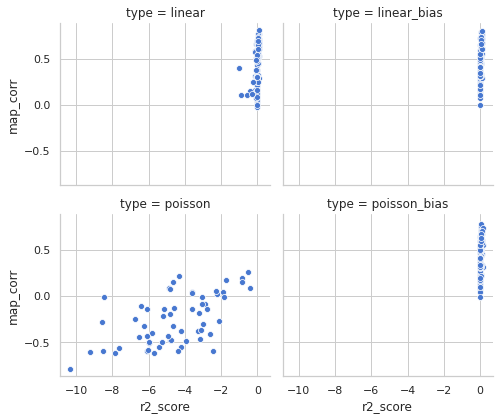

In [25]:
_=sns.relplot(x='r2_score', y='map_corr', col='type', data=scores_df, col_wrap=2, height=3, aspect=1.2)

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


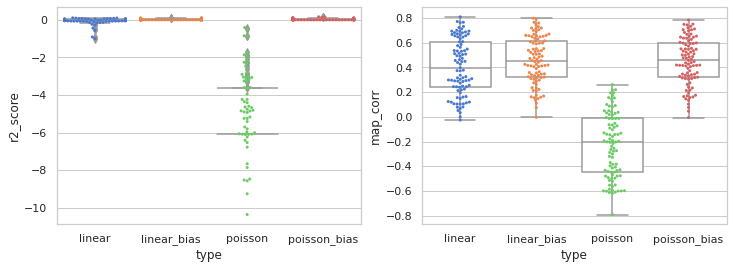

In [26]:
f,ax=plt.subplots(1,2, figsize=(12,4))
ax[0]=sns.boxplot(x='type', y='r2_score', data=scores_df, ax=ax[0], color='w')
ax[0]=sns.swarmplot(x='type', y='r2_score', data=scores_df,ax=ax[0], size=3)

ax[1]=sns.boxplot(x='type', y='map_corr', data=scores_df, ax=ax[1], color='w')
ax[1]=sns.swarmplot(x='type', y='map_corr', data=scores_df,ax=ax[1], size=3)

### remove scores without bias for better visualizations

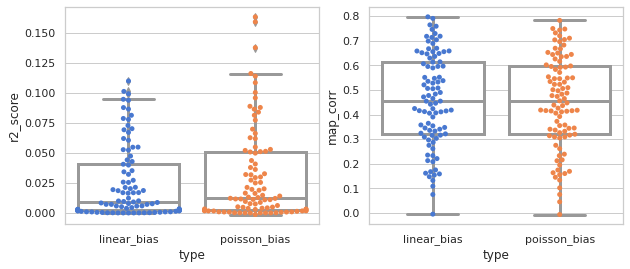

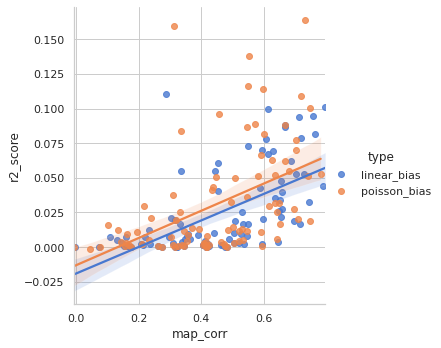

In [29]:
#dat_subset = scores_df[(scores_df['type']=='linear_bias') | (scores_df['type'] == 'poisson_bias')]
scores_bias_subset = scores_df[(scores_df['type']=='linear_bias') | (scores_df['type'] == 'poisson_bias')]

f,ax=plt.subplots(1,2, figsize=(10,4))
ax[0]=sns.boxplot(x='type', y='r2_score', data=scores_bias_subset, ax=ax[0], color='w', linewidth=3)
ax[0]=sns.swarmplot(x='type', y='r2_score', data=scores_bias_subset, ax=ax[0], size=5)
#ax[1]=sns.regplot(x='map_corr',y='r2_score', hue='type', data=scores_bias_subset,ax=ax[1])

#f,ax=plt.subplots(1)
ax[1]=sns.boxplot(x='type', y='map_corr', data=scores_bias_subset, ax=ax[1], color='w', linewidth=3)
ax[1]=sns.swarmplot(x='type', y='map_corr', data=scores_bias_subset,ax=ax[1], size=5)

g=sns.lmplot(x='map_corr',y='r2_score', hue='type', data=scores_bias_subset)

R2 Wilcoxon Test
WilcoxonResult(statistic=990.0, pvalue=2.794326337397787e-06)

Map Corr Wilcoxon Test
WilcoxonResult(statistic=1117.0, pvalue=2.593819644391301e-05)


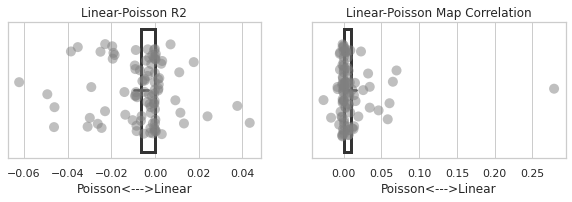

In [30]:
f, ax = plt.subplots(1,2, figsize=(10,2.5))
r2_diff = scores_bias_subset[scores_bias_subset['type']=='linear_bias' ]['r2_score'].values-scores_bias_subset[scores_bias_subset['type']=='poisson_bias' ]['r2_score'].values
sns.barplot(r2_diff, ax=ax[0], edgecolor='0.2',linewidth=3, color='white')
sns.stripplot(r2_diff,ax=ax[0], color='grey',alpha=0.5, size=10, jitter=0.3)
ax[0].set(
    title='Linear-Poisson R2',
    xlabel='Poisson<--->Linear')

map_corr_diff = scores_bias_subset[scores_bias_subset['type']=='linear_bias' ]['map_corr'].values-scores_bias_subset[scores_bias_subset['type']=='poisson_bias' ]['map_corr'].values
sns.stripplot(map_corr_diff,ax=ax[1],color='grey',alpha=0.5, size=10, jitter=0.3)
sns.barplot(map_corr_diff, edgecolor='0.2', linewidth=3, ax=ax[1],  color='white')

_=ax[1].set(
    title='Linear-Poisson Map Correlation',
    xlabel='Poisson<--->Linear')

print('R2 Wilcoxon Test')
print(stats.wilcoxon(scores_bias_subset[scores_bias_subset['type']=='linear_bias' ]['r2_score'].values, scores_bias_subset[scores_bias_subset['type']=='poisson_bias' ]['r2_score'].values))
#sns.jointplot(x='r2_score', y='map_corr', hue="type", kind="reg", data=scores_bias_subset)
print()
print('Map Corr Wilcoxon Test')
print(stats.wilcoxon(scores_bias_subset[scores_bias_subset['type']=='linear_bias' ]['map_corr'].values, scores_bias_subset[scores_bias_subset['type']=='poisson_bias' ]['map_corr'].values))

Poisson models are bit a better explaining variance in time dimensions, while linear models tend to be slightly better at predicting maps.

# Modify encoding model to have field specific firing rates

In the above analyses scale, phase and moire grid were computed. skipping those computations here.

In [31]:

spatial_funcs = reload(spatial_funcs)

r2_scores_fields = pd.DataFrame(index=range(n_units), columns=['linear', 'linear_bias', 'poisson', 'poisson_bias'])
map_corr_fields = pd.DataFrame(index=range(n_units), columns=['linear', 'linear_bias', 'poisson', 'poisson_bias'])

options = {'linear': {'reg_type':'linear', 'bias_term': False},
           'linear_bias': {'reg_type':'linear', 'bias_term': True}, 
           'poisson': {'reg_type':'poisson', 'bias_term': False}, ## very poor perf.
           'poisson_bias': {'reg_type':'poisson', 'bias_term': True}}

for unit in range(n_units):
    session_id = unit_info_table.loc[unit,'sessions_id']-1
    unit_id = unit_info_table.loc[unit,'session_units_id']
    
     # get data
    x = data['behav_ts'][session_id]['x']
    y = data['behav_ts'][session_id]['y']
    spk = data['spikes'][session_id][unit_id]
    fr = data['fr'][session_id][unit_id]        
    fr_map = data['neural_maps'][session_id][unit_id]
    
    try:
         with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            # normalize firing rate map (max=1)
            fr_map_max = fr_map.max()
            fr_map = fr_map/fr_map_max
            
            # instead of feeding in the moire grid to encoding map fit, I create a tensor with the fields
            # fields maps = n_fields x height x width
            # such that each field map becomes a feature of the model and each can have an independent fit
            fields,n_fields=spatial_funcs.get_map_fields(moire_fits[unit])
            field_maps = np.zeros((n_fields, height, width))
            for field_id in range(n_fields):
                field_maps[field_id] = fields==field_id


            for opt, vals in options.items(): 
                if vals['reg_type']=='poisson':
                    spk_hat, _, r2,_, _ = spatial_funcs.get_encoding_map_fit(spk, field_maps, x, y, x_edges=x_edges, y_edges=y_edges, **vals)
                    fr_map_hat = spatial_funcs.spikes_2_rate_map(spk_hat.flatten(), x, y, x_edges=x_edges, y_edges=y_edges)
                else:
                    fr_hat, _, r2,_, _ = spatial_funcs.get_encoding_map_fit(fr, field_maps, x, y, x_edges=x_edges, y_edges=y_edges, **vals)
                    fr_map_hat = spatial_funcs.firing_rate_2_rate_map(fr_hat.flatten(), x, y, x_edges=x_edges, y_edges=y_edges)

                r2_scores_fields.at[unit, opt] = r2
                map_corr_fields.at[unit, opt] = rs.spearman(fr_map.flatten(), fr_map_hat.flatten())

            print('.',end='')

    except:
        #traceback.print_exc(file=sys.stdout)
        print('_',end='')
       # break
        
r2_scores_fields = r2_scores_fields.astype(float)
map_corr_fields = map_corr_fields.astype(float)

r2_scores_fields['unit'] = np.arange(n_units)
scores_df_fields = r2_scores_fields.melt(id_vars='unit',var_name='type', value_name='r2_score')

map_corr_fields['unit'] = np.arange(n_units)
map_df_fields = map_corr_fields.melt(id_vars='unit',var_name='type', value_name='map_corr')

scores_df_fields['map_corr'] = map_df_fields['map_corr']

......................................................................_.......................

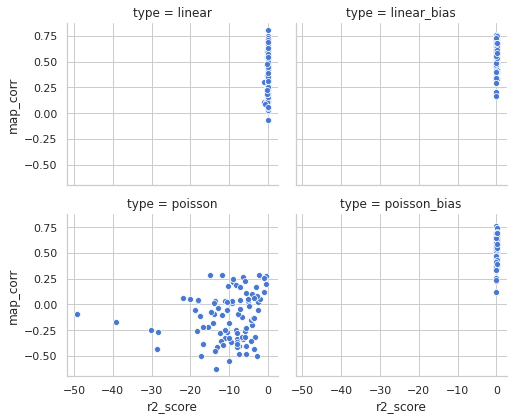

In [32]:
_=sns.relplot(x='r2_score', y='map_corr', col='type', data=scores_df_fields, col_wrap=2, height=3, aspect=1.2)

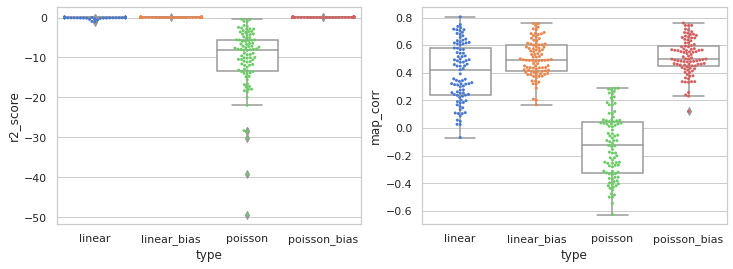

In [33]:
f,ax=plt.subplots(1,2, figsize=(12,4))
ax[0]=sns.boxplot(x='type', y='r2_score', data=scores_df_fields, ax=ax[0], color='w')
ax[0]=sns.swarmplot(x='type', y='r2_score', data=scores_df_fields,ax=ax[0], size=3)

ax[1]=sns.boxplot(x='type', y='map_corr', data=scores_df_fields, ax=ax[1], color='w')
ax[1]=sns.swarmplot(x='type', y='map_corr', data=scores_df_fields, ax=ax[1], size=3)

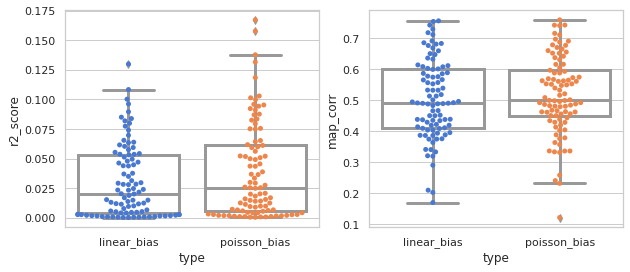

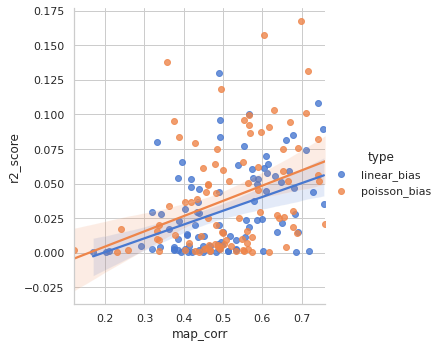

In [34]:
scores_bias_subset = scores_df_fields[(scores_df_fields['type']=='linear_bias') | (scores_df_fields['type'] == 'poisson_bias')]

f,ax=plt.subplots(1,2, figsize=(10,4))
ax[0]=sns.boxplot(x='type', y='r2_score', data=scores_bias_subset, ax=ax[0], color='w', linewidth=3)
ax[0]=sns.swarmplot(x='type', y='r2_score', data=scores_bias_subset, ax=ax[0], size=5)
#ax[1]=sns.regplot(x='map_corr',y='r2_score', hue='type', data=scores_bias_subset,ax=ax[1])

#f,ax=plt.subplots(1)
ax[1]=sns.boxplot(x='type', y='map_corr', data=scores_bias_subset, ax=ax[1], color='w', linewidth=3)
ax[1]=sns.swarmplot(x='type', y='map_corr', data=scores_bias_subset,ax=ax[1], size=5)

g=sns.lmplot(x='map_corr',y='r2_score', hue='type', data=scores_bias_subset)

R2 Wilcoxon Test
WilcoxonResult(statistic=1010.0, pvalue=4.027320588964977e-06)

Map Corr Wilcoxon Test
WilcoxonResult(statistic=1307.0, pvalue=0.00048302075840200956)


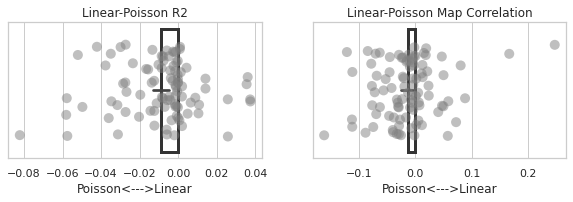

In [35]:
f, ax = plt.subplots(1,2, figsize=(10,2.5))
r2_diff = scores_bias_subset[scores_bias_subset['type']=='linear_bias' ]['r2_score'].values-scores_bias_subset[scores_bias_subset['type']=='poisson_bias' ]['r2_score'].values
sns.barplot(r2_diff, ax=ax[0], edgecolor='0.2',linewidth=3, color='white')
sns.stripplot(r2_diff,ax=ax[0], color='grey',alpha=0.5, size=10, jitter=0.3)
ax[0].set(
    title='Linear-Poisson R2',
    xlabel='Poisson<--->Linear')

map_corr_diff = scores_bias_subset[scores_bias_subset['type']=='linear_bias' ]['map_corr'].values-scores_bias_subset[scores_bias_subset['type']=='poisson_bias' ]['map_corr'].values
sns.stripplot(map_corr_diff,ax=ax[1],color='grey',alpha=0.5, size=10, jitter=0.3)
sns.barplot(map_corr_diff, edgecolor='0.2', linewidth=3, ax=ax[1],  color='white')

_=ax[1].set(
    title='Linear-Poisson Map Correlation',
    xlabel='Poisson<--->Linear')

print('R2 Wilcoxon Test')
print(stats.wilcoxon(scores_bias_subset[scores_bias_subset['type']=='linear_bias' ]['r2_score'].values, scores_bias_subset[scores_bias_subset['type']=='poisson_bias' ]['r2_score'].values))
#sns.jointplot(x='r2_score', y='map_corr', hue="type", kind="reg", data=scores_bias_subset)
print()
print('Map Corr Wilcoxon Test')
print(stats.wilcoxon(scores_bias_subset[scores_bias_subset['type']=='linear_bias' ]['map_corr'].values, scores_bias_subset[scores_bias_subset['type']=='poisson_bias' ]['map_corr'].values))

In this case, Poisson models outperform linear models in both metrics.

### Compare between models that have individual fields as predictors:

In [36]:
a1=scores_df.rename(columns={'r2_score': 'r2', 'map_corr': 'mc'})
a1['feature'] = 'grid'
a2=scores_df_fields.rename(columns={'r2_score': 'r2', 'map_corr': 'mc'})
a2['feature'] = 'fields'
scores_all = pd.concat((a1,a2))
scores_all.head()

,unit,type,r2,mc,feature
0,0,linear,-0.022828,0.376880,grid
1,1,linear,-0.092250,0.112873,grid
2,2,linear,0.006325,0.561342,grid
3,3,linear,-0.027342,0.033601,grid
4,4,linear,-0.008313,0.195537,grid


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


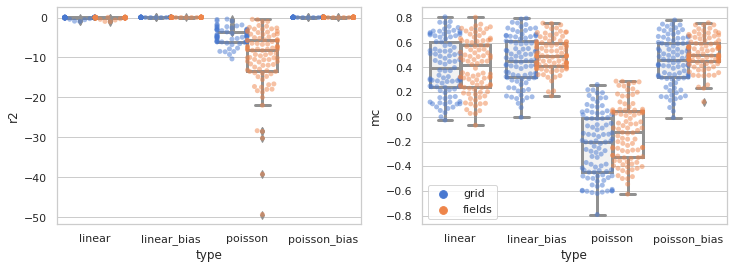

In [37]:
f,ax=plt.subplots(1,2, figsize=(12,4))
ax[0]=sns.boxplot(x='type', y='r2', hue='feature', data=scores_all, ax=ax[0], color='w', linewidth=3)
ax[0]=sns.swarmplot(x='type', y='r2', hue='feature', data=scores_all, ax=ax[0], size=5, dodge=True, alpha=0.5)
#ax[1]=sns.regplot(x='map_corr',y='r2_score', hue='type', data=scores_bias_subset,ax=ax[1])
ax[0].get_legend().remove()

#f,ax=plt.subplots(1)
ax[1]=sns.boxplot(x='type', y='mc',  hue='feature', data=scores_all, ax=ax[1], color='w', linewidth=3)
ax[1]=sns.swarmplot(x='type', y='mc', hue='feature', data=scores_all,ax=ax[1], size=5, dodge=True, alpha=0.5)
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles=handles[2:], labels=labels[2:])

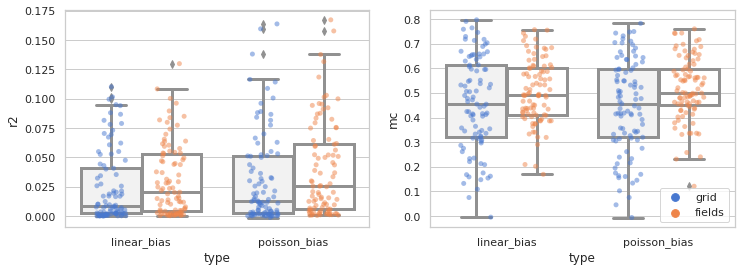

In [38]:
scores_bias_subset = scores_all[(scores_all['type']=='linear_bias') | (scores_all['type'] == 'poisson_bias')]

f,ax=plt.subplots(1,2, figsize=(12,4))
ax[0]=sns.boxplot(x='type', y='r2', hue='feature', data=scores_bias_subset, ax=ax[0], color='w', linewidth=3)
ax[0]=sns.stripplot(x='type', y='r2', hue='feature', data=scores_bias_subset,ax=ax[0], size=5, dodge=True, jitter=0.2,alpha=0.5)
ax[0].get_legend().remove()
#ax[1]=sns.regplot(x='map_corr',y='r2_score', hue='type', data=scores_bias_subset,ax=ax[1])

#f,ax=plt.subplots(1)
ax[1]=sns.boxplot(x='type', y='mc',  hue='feature', data=scores_bias_subset, ax=ax[1], color='w', linewidth=3)
ax[1]=sns.stripplot(x='type', y='mc', hue='feature', data=scores_bias_subset,ax=ax[1], size=5, dodge=True, jitter=0.2,alpha=0.5)

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles=handles[2:], labels=labels[2:])

Text(0.5, 1.0, 'Models Poisson_Bias Map Corr ')

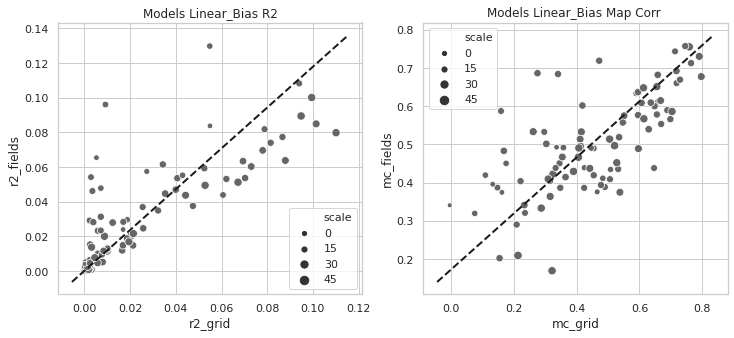

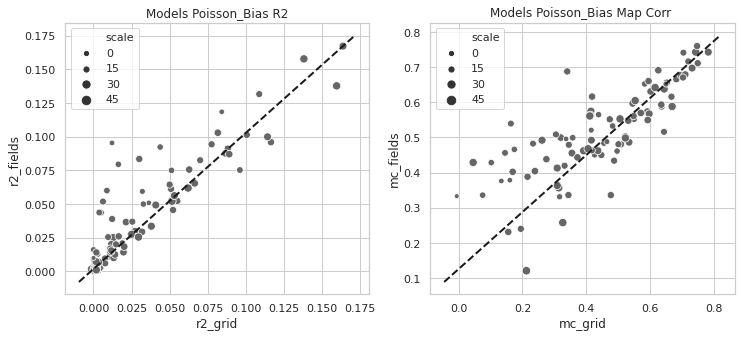

In [39]:

idx_x = (scores_bias_subset['feature']=='grid')
idx_y = (scores_bias_subset['feature']=='fields')

idx=(scores_bias_subset['type']=='linear_bias')
dat_subset = pd.DataFrame(columns = ['r2_grid', 'r2_fields', 'scale'])
dat_subset['r2_grid'] = scores_bias_subset['r2'][idx & idx_x].values
dat_subset['r2_fields'] = scores_bias_subset['r2'][idx & idx_y].values
dat_subset['scale'] = unit_grid_scales

f, ax = plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(data=dat_subset, x='r2_grid', y='r2_fields', size='scale', color='0.4', ax=ax[0])
ax[0].plot(ax[0].get_xlim(), ax[0].get_ylim(), ls="--", color='k', linewidth=2)
ax[0].set_title('Models Linear_Bias R2')

dat_subset = pd.DataFrame(columns = ['mc_grid', 'mc_fields', 'scale'])
dat_subset['mc_grid'] = scores_bias_subset['mc'][idx & idx_x].values
dat_subset['mc_fields'] = scores_bias_subset['mc'][idx & idx_y].values
dat_subset['scale'] = unit_grid_scales

sns.scatterplot(data=dat_subset, x='mc_grid', y='mc_fields', size='scale', color='0.4', ax=ax[1])
ax[1].plot(ax[1].get_xlim(), ax[1].get_ylim(), ls="--", color='k', linewidth=2)
ax[1].set_title('Models Linear_Bias Map Corr ')

#-----


idx=(scores_bias_subset['type']=='poisson_bias')
dat_subset = pd.DataFrame(columns = ['r2_grid', 'r2_fields', 'scale'])
dat_subset['r2_grid'] = scores_bias_subset['r2'][idx & idx_x].values
dat_subset['r2_fields'] = scores_bias_subset['r2'][idx & idx_y].values
dat_subset['scale'] = unit_grid_scales


f, ax = plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(data=dat_subset, x='r2_grid', y='r2_fields', size='scale', color='0.4', ax=ax[0])
#ax[0].plot([0,1],[0,1], color='k', linewidth=2, linestyle='--', transform=ax[0].transAxes,)
ax[0].plot(ax[0].get_xlim(), ax[0].get_ylim(), ls="--", color='k', linewidth=2)
ax[0].set_title('Models Poisson_Bias R2')

dat_subset = pd.DataFrame(columns = ['mc_grid', 'mc_fields', 'scale'])
dat_subset['mc_grid'] = scores_bias_subset['mc'][idx & idx_x].values
dat_subset['mc_fields'] = scores_bias_subset['mc'][idx & idx_y].values
dat_subset['scale'] = unit_grid_scales

sns.scatterplot(data=dat_subset, x='mc_grid', y='mc_fields', size='scale', color='0.4', ax=ax[1])
ax[1].plot(ax[1].get_xlim(), ax[1].get_ylim(), ls="--", color='k', linewidth=2)
ax[1].set_title('Models Poisson_Bias Map Corr ')


## Create a function to separate data for xval purposes
A data set is composed of spikes, fr, x-y positions. Split the data into two groups, where every minute the first 30 seconds go into one group, and the second 30 secs go into the other.

In [41]:
# reformat ts data for convenience
session_ts_data = {}
behav_ts_keys = ['x', 'y', 'ha', 'hd', 'speed']
for session_id in range(n_sessions):
    # behavioral ts
    session_ts_data[session_id] = {}
    for key in behav_ts_keys:
        session_ts_data[session_id][key] = data['behav_ts'][session_id][key].values
    # neural ts
    session_ts_data[session_id]['spikes'] = data['spikes'][session_id]
    session_ts_data[session_id]['fr'] = data['fr'][session_id]
    
data_path = Path('/home/alexgonzalez/Documents/data/butler_hardcastle')
file_name = 'grid_cell_ts_data.pickle'
with (data_path/file_name).open(mode='wb') as f:
    pickle.dump(session_ts_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
# this function splits a sesions time series data into two time series for split half analyses
# to do; make it an arbitrary number of splits
def split_timeseries_data(data_set, samp_rate=0.02, split_interval=30):
    
   
    n_total_samps = len(data_set['x'])
    total_time = n_total_samps*samp_rate
    
    n_splits = np.ceil(total_time/split_interval)
    split_interval_samps = int(split_interval/samp_rate)
    split_edges = np.append(np.arange(0,n_total_samps, split_interval_samps), n_total_samps)

    split_samps = np.zeros(n_total_samps,dtype=bool)
    for ii in np.arange(0,n_splits,2,dtype=int):
        split_samps[split_edges[ii]:split_edges[ii+1]] = 1

    n_split1_samps = split_samps.sum()
    n_split2_samps = (~split_samps).sum()

    out_data = {}
    out_data['split1'] = {}
    out_data['split2'] = {}
    for key, ts in data_set.items():  # for every timeseries in the data
        
        if key in ['spikes','fr']:
            out_data['split1'][key] = ts[:, split_samps]
            out_data['split2'][key] = ts[:, ~split_samps]
        else:
            out_data['split1'][key] = ts[split_samps]
            out_data['split2'][key] = ts[~split_samps]
    
    return out_data


In [294]:
def _split_timeseries_data(data, n_splits=2, samp_rate=0.02, split_interval=30):
    
    n_ts = len(data)
    ts_lengths = np.zeros(n_ts)
    cnt=0
    for key, ts in data.items():
        ts_lengths[cnt]=max(ts.shape)
        cnt+=1
    assert np.all(ts_lengths[0]==ts_lengths), "Time series have different lengths."
    
    n_total_samps = ts_length[0]
    
    split_interval_samps = int(split_interval/samp_rate)
    split_edges = np.append(np.arange(0,n_total_samps, split_interval_samps), n_total_samps)
    n_split_segments = len(split_edges)-1
    
    split_samps = np.zeros(n_total_samps,dtype=int)
    for ii in np.arange(0,n_split_segments, dtype=int):
        split_id = np.mod(ii,n_splits)
        split_samps[split_edges[ii]:split_edges[ii+1]] = split_id

    out_data = {}
    for key, ts in data.items():  # for every timeseries in the data
        out_data[key] = np.empty(n_splits, dtype=object)
        dim = np.where(np.array(ts.shape) == n_total_samps)[0]
        
        if dim>0:
            ts_temp = np.moveaxis(ts, dim, 0)
            for split in range(n_splits):
                out_data[key][split] = np.moveaxis(ts_temp[split_samps==split], 0, dim)
        else:
            for split in range(n_splits):
                out_data[key][split] = ts[split_samps==split]
    
    return out_data

In [297]:
split_data_2 = {}
n_splits = 3
for session_id in range(n_sessions):
    n_samps = len(session_ts_data[session_id]['x'])
    split_data_2[session_id] = _split_timeseries_data(session_ts_data[session_id], n_samps, n_splits=n_splits)

In [298]:
session_id = 5
print([split_data_2[session_id]['fr'][i].shape for i in range(n_splits)])
print([split_data_2[session_id]['x'][i].shape for i in range(n_splits)])
print(len(session_ts_data[session_id]['x']))

[(4, 40500), (4, 40343), (4, 39000)]
[(40500,), (40343,), (39000,)]
119843


In [302]:
n_ts = len(session_ts_data[session_id])
ts_lengths = np.zeros(n_ts)
cnt=0
for key, ts in session_ts_data[session_id].items():
    ts_lengths[cnt]=max(ts.shape)
    cnt+=1


True

In [42]:
# split data
split_data = {}
for session_id in range(n_sessions):
    split_data[session_id] =     :param x_bin_edges: bin edges in the x position
    :param y_bin_edges: bin edges in the y position(session_ts_data[session_id])

### Make models using split half data and test on the other half.
Using Poisson nl-fields approach as it was the most successful above.

1. First need to recompute scale, phase, & moire fit for each split
2. Create models for each split, and test on the other. 
    - Four measures of interest: train R2, train MC, test R2, test MC.  (for each split, show the mean)
    moire_fit_split_data

## Step 1. Below. Note that running this cell takes time, if it has been run before go two cells down to load the results.

In [51]:
spatial_funcs = reload(spatial_funcs)

# Step 1 get scales and phases 
n_splits = 2
width = 50
height = 50
x_dim_cm = 150
y_dim_cm = 150
count_thr = 1 ## for firing rate maps computation

x_edges = np.linspace(0, x_dim_cm, width+1)
y_edges = np.linspace(0, y_dim_cm, height+1)

# pre-allocate
moire_split_fits = np.zeros((n_splits, n_units,height, width))
fr_split_maps = np.zeros((n_splits, n_units,height, width)) 
unit_split_grid_scales = np.zeros((n_splits, n_units))*np.nan
unit_split_grid_phases = np.zeros((n_splits, n_units))*np.nan
unit_split_gs = np.zeros((n_splits, n_units))*np.nan

for unit in range(n_units):
    session_id = unit_info_table.loc[unit,'sessions_id']-1
    unit_id = unit_info_table.loc[unit,'session_units_id']
    
    try:
        for split in range(n_splits):
            # get data
            fr = split_data[session_id]['split'+str(split+1)]['fr'][unit_id]
            x = split_data[session_id]['split'+str(split+1)]['x']
            y = split_data[session_id]['split'+str(split+1)]['y']

            # normally the count thr for each spatial bin is 3 [60ms] , lowering that to 1 [20ms]. 
            fr_map = spatial_funcs.firing_rate_2_rate_map(fr=fr, x=x, y=y, x_edges=x_edges, y_edges=y_edges, count_thr=count_thr)
            
            nl_fr_map = spatial_funcs.sigmoid(fr_map/fr_map.max(),**sigmoid_params)
            fields_map, n_fields = spatial_funcs.get_map_fields(nl_fr_map, fr_thr=0.1)
            thr_fr_map = (fields_map>=0)*nl_fr_map

            # if sufficient fields for gs computation:
            if n_fields>=3:
                unit_split_gs[split, unit], unit_split_grid_scales[split, unit], unit_split_grid_phases[split, unit], _ = spatial_funcs.compute_grid_score(thr_fr_map, non_linearity=1)
                max_field_loc = np.unravel_index(np.argmax(fr_map), fr_map.shape)
                moire_split_fits[split, unit] = spatial_funcs.generate_moire_grid(width, height, [max_field_loc[1], max_field_loc[0]], scale=unit_split_grid_scales[split, unit], theta=unit_split_grid_phases[split, unit])             
            else:
                temp = spatial_funcs.fit_moire_grid(fr_map)
                unit_split_grid_scales[split, unit] = temp[0]
                unit_split_grid_phases[split, unit] = temp[1]
                moire_split_fits[split, unit] = temp[2]

            fr_split_maps[split, unit] = fr_map
    
        print('.',end='')
    except:
        #traceback.print_exc(file=sys.stdout)
        #break
        print(f'_{unit}_',end='')


......................................................................

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Analyses/spatial_functions.py:1477: RuntimeWarning: invalid value encountered in true_divide
  fr_map = fr_map / fr_map.max()


........................

The above computation takes a couple of minutes. Saving the results in case of interrupted kernel.

In [52]:
# save
data_path = Path('/home/alexgonzalez/Documents/data/butler_hardcastle')
file_name = 'grid_cell_split_moire_fits.pickle'

moire_fit_split_data = {'moire_split_fits': moire_split_fits, 'fr_split_maps': fr_split_maps, 
                        'unit_split_grid_scales': unit_split_grid_scales, 
                        'unit_split_grid_phases': unit_split_grid_phases, 
                        'unit_split_gs': unit_split_gs}

with (data_path/file_name).open(mode='wb') as f:
    pickle.dump(moire_fit_split_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
# load data
data_path = Path('/home/alexgonzalez/Documents/data/butler_hardcastle')
file_name = 'grid_cell_split_moire_fits.pickle'
with (data_path / file_name).open('rb') as f:
    moire_fit_split_data = pickle.load(f)
    
moire_split_fits = moire_fit_split_data['moire_split_fits']
fr_split_maps = moire_fit_split_data['fr_split_maps']
unit_split_grid_scales = moire_fit_split_data['unit_split_grid_scales']
unit_split_grid_phases = moire_fit_split_data['unit_split_grid_phases']
unit_split_gs = moire_fit_split_data['unit_split_gs']

del moire_fit_split_data

### Compare results to whole set

Text(0.5, 1.0, 'Scale Split Difference')

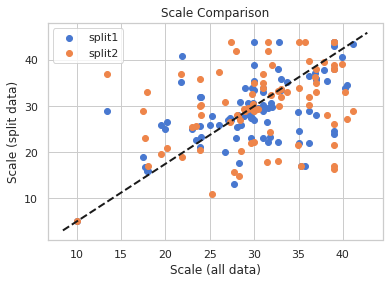

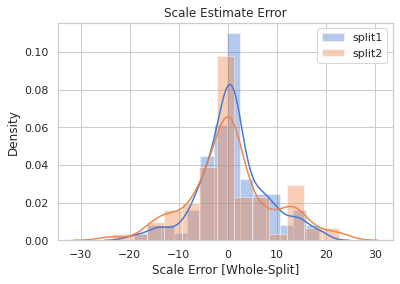

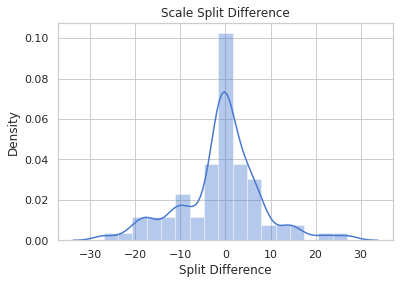

In [44]:
x = unit_grid_scales
y1= unit_split_grid_scales[0,:]
y2= unit_split_grid_scales[1,:]

f,ax=plt.subplots()
ax.scatter(x,y1,label='split1')
ax.scatter(x,y2,label='split2')
ax.legend()
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", color='k', linewidth=2)
ax.set_xlabel('Scale (all data)')
ax.set_ylabel('Scale (split data)')
ax.set_title('Scale Comparison')

f,ax=plt.subplots()
ax = sns.distplot(x-y1,label='split1')
ax = sns.distplot(x-y2, label='split2',ax=ax)
ax.legend()
ax.set_xlabel('Scale Error [Whole-Split]')
ax.set_ylabel('Density')
ax.set_title('Scale Estimate Error')

f,ax=plt.subplots()
ax = sns.distplot(y1-y2)
ax.set_xlabel('Split Difference')
ax.set_ylabel('Density')
ax.set_title('Scale Split Difference')


In [45]:
@interact_manual(unit=(0,n_units-1))

def _maps2(unit):
    session_id = unit_info_table.loc[unit,'sessions_id']-1
    unit_id = unit_info_table.loc[unit,'session_units_id']
    
    print(f'Session id:  {session_id}; Unit {unit_id}')
    print(unit_info_table.at[unit,'grid_cells_file_ids'])
    
    print('Estimates\n')
    print(f'Scales:')
    print(f'split1={unit_split_grid_scales[0, unit]:0.2f}, split2={unit_split_grid_scales[1, unit]:0.2f}')

    print()
    print('Phase:')
    print(f'split1={unit_split_grid_phases[0, unit]:0.2f}, split2={unit_split_grid_phases[1, unit]:0.2f}')
    
    f,ax = plt.subplots(2,3,figsize=(18,10))
    ax = ax.flatten()
    
    fr_map = data['neural_maps'][session_id][unit_id]
    fr_map_max = fr_map.max()
    fr_map = fr_map/fr_map_max

    fields_map, _ = spatial_funcs.get_map_fields(fr_map, fr_thr=fr_map_mean)
    thr_fr_map = (fields_map>=0)*fr_map
    
    plot_map(fr_map , ax=ax[0])
    ax[0].set_title(f'Whole: Rate Map Max={fr_map_max:0.2f}')
        
    a2 = rs.compute_autocorr_2d(thr_fr_map)
    #a2=signal.correlate2d(thr_fr_map,thr_fr_map,boundary='wrap')
    plot_map(a2 , ax=ax[3])
    ax[3].set_title(f"Thr Auto Corr: Sc={unit_grid_scales[unit]:0.2f}")


    fr_map = fr_split_maps[0, unit]
    fr_map_max = fr_map.max()
    fr_map = fr_map/fr_map_max

    fields_map, _ = spatial_funcs.get_map_fields(fr_map, fr_thr=fr_map_mean)
    thr_fr_map = (fields_map>=0)*fr_map
    
    plot_map(fr_map , ax=ax[1])
    ax[1].set_title(f'Split1: Rate Map Max={fr_map_max:0.2f}')
        
    a2 = rs.compute_autocorr_2d(thr_fr_map)
    #a2=signal.correlate2d(thr_fr_map,thr_fr_map,boundary='wrap')
    plot_map(a2 , ax=ax[4])
    ax[4].set_title(f"Thr Auto Corr: Sc={unit_split_grid_scales[0,unit]:0.2f}")

    
    fr_map = fr_split_maps[1, unit]
    fr_map_max = fr_map.max()
    fr_map = fr_map/fr_map_max

    fields_map, _ = spatial_funcs.get_map_fields(fr_map, fr_thr=fr_map_mean)
    thr_fr_map = (fields_map>=0)*fr_map
    
    plot_map(fr_map , ax=ax[2])
    ax[2].set_title(f'Split2: Rate Map Max={fr_map_max:0.2f}')
        
    a2 = rs.compute_autocorr_2d(thr_fr_map)
    #a2=signal.correlate2d(thr_fr_map,thr_fr_map,boundary='wrap')
    plot_map(a2 , ax=ax[5])
    ax[5].set_title(f"Thr Auto Corr: Sc={unit_split_grid_scales[1, unit]:0.2f}")


interactive(children=(IntSlider(value=46, description='unit', max=93), Button(description='Run Interact', styl…

## Step 2 and 3. Fit Poisson + bias models to splits and test on other half

In [61]:
spatial_funcs = reload(spatial_funcs)

n_splits = 2

r2_split_scores = pd.DataFrame(index=range(n_units), columns=['train_split1', 'train_split2', 'test_split1', 'test_split2'])
map_corr_split_scores = pd.DataFrame(index=range(n_units), columns=['train_split1', 'train_split2', 'test_split1', 'test_split2'])
#fr_map_hat_train = np.zeros((n_splits, n_units, width, height))
fr_map_hat_test = np.zeros((n_splits, n_units, width, height))

options = {'reg_type':'poisson', 'bias_term': True}

for unit in range(n_units):
    session_id = unit_info_table.loc[unit,'sessions_id']-1
    unit_id = unit_info_table.loc[unit,'session_units_id']

    # get data
    fr = {}
    spk = {}
    x = {}
    y = {}
    moire_fit = {}
    fr_map = {}
    for split in range(n_splits):
        fr[split] = split_data[session_id]['split'+str(split+1)]['fr'][unit_id]
        spk[split] = split_data[session_id]['split'+str(split+1)]['spikes'][unit_id]

        x[split] = split_data[session_id]['split'+str(split+1)]['x']
        y[split] = split_data[session_id]['split'+str(split+1)]['y']

        moire_fit[split] = moire_split_fits[split, unit]
        fr_map[split] = fr_split_maps[split, unit]

    # get fits and test
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')

            for split in range(n_splits):

                # instead of feeding in the moire grid to encoding map fit, I create a tensor with the fields
                # fields maps = n_fields x height x width
                # such that each field map becomes a feature of the model and each can have an independent fit
                fields,n_fields=spatial_funcs.get_map_fields(moire_fit[split])
                field_maps = np.zeros((n_fields, height, width))
                for field_id in range(n_fields):
                    field_maps[field_id] = fields==field_id

                # train
                spk_hat, coefs, r2,_, _ = spatial_funcs.get_encoding_map_fit(spk[split], field_maps, x[split], y[split], x_edges=x_edges, y_edges=y_edges, **options)
                #fr_map_hat_train[split, unit] = spatial_funcs.spikes_2_rate_map(spk_hat.flatten(), x[split], y[split], x_edges=x_edges, y_edges=y_edges)
                fr_map_hat_train = spatial_funcs.spikes_2_rate_map(spk_hat.flatten(), x[split], y[split], x_edges=x_edges, y_edges=y_edges)

                
                # train scores
                r2_split_scores.at[unit, 'train_split'+str(split+1)] = r2
                map_corr_split_scores.at[unit, 'train_split'+str(split+1)] = rs.spearman(fr_map[split].flatten(), fr_map_hat_train.flatten())
                #map_corr_split_scores.at[unit, 'train_split'+str(split+1)] = rs.spearman(fr_map[split].flatten(), fr_map_hat_train[split, unit].flatten())


                # test 
                t_split = np.mod(split+1,2)

                spk_test_hat, test_r2, _, _ = spatial_funcs.get_encoding_map_predictions(spk[t_split], field_maps, coefs, 
                                                                                         x[t_split], y[t_split], x_edges=x_edges, y_edges=y_edges, **options)

                fr_map_hat_test[t_split, unit] = spatial_funcs.spikes_2_rate_map(spk_test_hat.flatten(), x[t_split], y[t_split], x_edges=x_edges, y_edges=y_edges)

                r2_split_scores.at[unit, 'test_split'+str(t_split+1)] = test_r2
                map_corr_split_scores.at[unit, 'test_split'+str(t_split+1)] = rs.spearman(fr_map[t_split].flatten(), fr_map_hat_test[split, unit].flatten())

                print('.',end='')
    except KeyboardInterrupt:
        print('Keyboard Interrupt.')
        break
        
    except:
        #traceback.print_exc(file=sys.stdout)
        print('_',end='')
        #break

    

# r2_scores_fields = r2_scores_fields.astype(float)
# map_corr_fields = map_corr_fields.astype(float)

# r2_scores_fields['unit'] = np.arange(n_units)
# scores_df_fields = r2_scores_fields.melt(id_vars='unit',var_name='type', value_name='r2_score')

# map_corr_fields['unit'] = np.arange(n_units)
# map_df_fields = map_corr_fields.melt(id_vars='unit',var_name='type', value_name='map_corr')

# scores_df_fields['map_corr'] = map_df_fields['map_corr']

..........Keyboard Interrupt.


In [243]:
%%time
spatial_funcs = reload(spatial_funcs)

n_splits = 2

r2_split_scores = pd.DataFrame(index=range(n_units), columns=['train_split1', 'train_split2', 'test_split1', 'test_split2'])
map_corr_split_scores = pd.DataFrame(index=range(n_units), columns=['train_split1', 'train_split2', 'test_split1', 'test_split2'])
fr_map_hat_train = np.zeros((n_splits, n_units, width, height))
fr_map_hat_test = np.zeros((n_splits, n_units, width, height))

options = {'reg_type':'poisson', 'bias_term': True}

for unit in range(n_units):
    session_id = unit_info_table.loc[unit,'sessions_id']-1
    unit_id = unit_info_table.loc[unit,'session_units_id']

    # get data
    fr = {}
    spk = {}
    x = {}
    y = {}
    moire_fit = {}
    fr_map = {}
    for split in range(n_splits):
        fr[split] = split_data[session_id]['split'+str(split+1)]['fr'][unit_id]
        spk[split] = split_data[session_id]['split'+str(split+1)]['spikes'][unit_id]

        x[split] = split_data[session_id]['split'+str(split+1)]['x']
        y[split] = split_data[session_id]['split'+str(split+1)]['y']

        moire_fit[split] = moire_split_fits[split, unit]
        fr_map[split] = fr_split_maps[split, unit]

    # get fits and test
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')

            for split in range(n_splits):

                # instead of feeding in the moire grid to encoding map fit, I create a tensor with the fields
                # fields maps = n_fields x height x width
                # such that each field map becomes a feature of the model and each can have an independent fit
                fields,n_fields=spatial_funcs.get_map_fields(moire_fit[split])
                field_maps = np.zeros((n_fields, height, width))
                for field_id in range(n_fields):
                    field_maps[field_id] = fields==field_id

                # train
                spk_hat_train, coefs, r2,_, _ = spatial_funcs.get_encoding_map_fit(spk[split], field_maps, x[split], y[split], x_edges=x_edges, y_edges=y_edges, **options)
                # sample from poisson
                spk_hat_train = stats.poisson(spk_hat_train.flatten()).rvs()
                # get map
                fr_map_hat_train[split, unit] = spatial_funcs.spikes_2_rate_map(spk_hat_train.flatten(), x[split], y[split], x_edges=x_edges, y_edges=y_edges)
               
                # train scores
                r2_split_scores.at[unit, 'train_split'+str(split+1)] = r2
                map_corr_split_scores.at[unit, 'train_split'+str(split+1)] = rs.pearson(fr_map[split].flatten(), fr_map_hat_train[split, unit].flatten())


                # test 
                t_split = np.mod(split+1,2)
                spk_hat_test, test_r2, _, _ = spatial_funcs.get_encoding_map_predictions(spk[t_split], field_maps, coefs, 
                                                                                         x[t_split], y[t_split], x_edges=x_edges, y_edges=y_edges, **options)
                # sample from poisson
                spk_hat_test = stats.poisson(spk_hat_test.flatten()).rvs()
                # get map
                fr_map_hat_test[t_split, unit] = spatial_funcs.spikes_2_rate_map(spk_hat_test, x[t_split], y[t_split], x_edges=x_edges, y_edges=y_edges)

                # test scores
                r2_split_scores.at[unit, 'test_split'+str(t_split+1)] = test_r2
                map_corr_split_scores.at[unit, 'test_split'+str(t_split+1)] = rs.pearson(fr_map[t_split].flatten(), fr_map_hat_test[t_split, unit].flatten())

                print('.',end='')
    except KeyboardInterrupt:
        print('Keyboard Interrupt.')
        break
        
    except:
        traceback.print_exc(file=sys.stdout)
        print('_',end='')
        #break

    
r2_split_scores = r2_split_scores.astype(float) 
map_corr_split_scores = map_corr_split_scores.astype(float)

# r2_scores_fields = r2_scores_fields.astype(float)
# map_corr_fields = map_corr_fields.astype(float)

# r2_scores_fields['unit'] = np.arange(n_units)
# scores_df_fields = r2_scores_fields.melt(id_vars='unit',var_name='type', value_name='r2_score')

# map_corr_fields['unit'] = np.arange(n_units)
# map_df_fields = map_corr_fields.melt(id_vars='unit',var_name='type', value_name='map_corr')

# scores_df_fields['map_corr'] = map_df_fields['map_corr']

............................................................................................................................................................................................CPU times: user 2min 15s, sys: 2.24 s, total: 2min 17s
Wall time: 17 s


In [178]:
r2_split_scores = r2_split_scores.astype(float) 
map_corr_split_scores = map_corr_split_scores.astype(float)

Relationship between train/test R2 splits


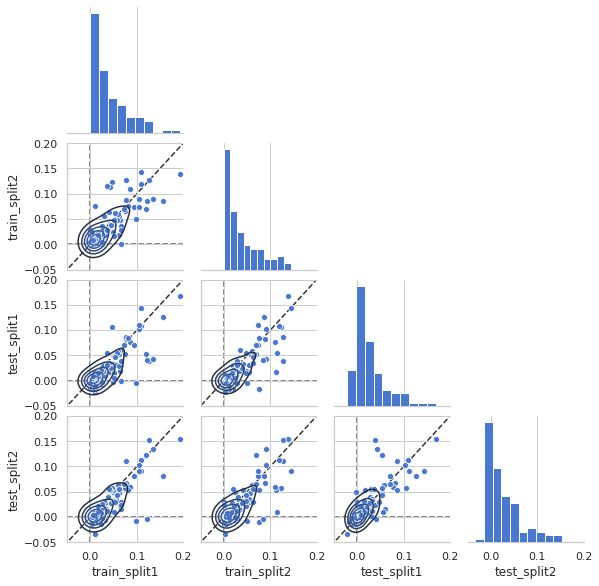

In [244]:
g=sns.pairplot(data=r2_split_scores, corner=True,height=2)
g.map_lower(sns.kdeplot, levels=5)

lims = [-0.05, 0.2]
diag = [-1,1]
for ii in range(1,4):
    for jj in range(ii):
        g.axes[ii,jj].plot(diag,diag, color='0.2',ls='--', zorder=0)
        g.axes[ii,jj].axvline(0, color='0.4',ls='--',zorder=0)
        g.axes[ii,jj].axhline(0, color='0.4',ls='--',zorder=0)
        g.axes[ii,jj].set_xlim(lims)
        g.axes[ii,jj].set_ylim(lims)
for ii in range(4):
    g.axes[ii,ii].set_xlim(lims)

print('Relationship between train/test R2 splits')

Relationship between train/test Map Correlations splits


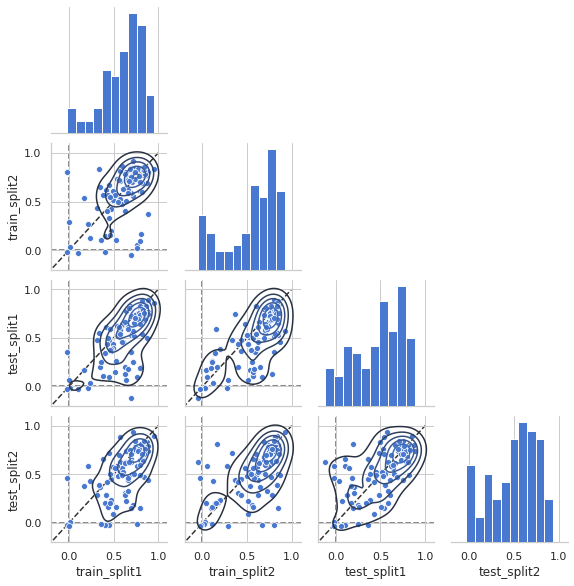

In [245]:
g=sns.pairplot(data=map_corr_split_scores, corner=True,height=2)
g.map_lower(sns.kdeplot, levels=5)

lims = [-0.2, 1.1]
diag = [-1,1]
for ii in range(1,4):
    for jj in range(ii):
        g.axes[ii,jj].plot(diag,diag, color='0.2',ls='--', zorder=0)
        g.axes[ii,jj].axvline(0, color='0.4',ls='--',zorder=0)
        g.axes[ii,jj].axhline(0, color='0.4',ls='--',zorder=0)
        g.axes[ii,jj].set_xlim(lims)
        g.axes[ii,jj].set_ylim(lims)
for ii in range(4):
    g.axes[ii,ii].set_xlim(lims)

print('Relationship between train/test Map Correlations splits')

In [187]:
map_corr_split_scores.at[0,'train_split1']

0.25777424401054433

In [246]:
@interact_manual(unit=(0,n_units-1))

def _maps2(unit):
    session_id = unit_info_table.loc[unit,'sessions_id']-1
    unit_id = unit_info_table.loc[unit,'session_units_id']
    
    print(f'Session id:  {session_id}; Unit {unit_id}')
    print(unit_info_table.at[unit,'grid_cells_file_ids'])
    
    print('Estimates\n')
    print(f'Scales:')
    print(f'split1={unit_split_grid_scales[0, unit]:0.2f}, split2={unit_split_grid_scales[1, unit]:0.2f}')

    print()
    print('Phase:')
    print(f'split1={unit_split_grid_phases[0, unit]:0.2f}, split2={unit_split_grid_phases[1, unit]:0.2f}')
    
    f,ax = plt.subplots(2,3,figsize=(18,10))
    ax = ax.flatten()
    
    fr_map = fr_split_maps[0, unit]
    fr_map_max = fr_map.max()
    fr_map = fr_map/fr_map_max
    plot_map(fr_map , ax=ax[0])
    ax[0].set_title(f'Split1: Rate Map Max={fr_map_max:0.2f}')
    
    fr_map = fr_map_hat_train[0,unit]
    fr_map_max = fr_map.max()
    fr_map = fr_map/fr_map_max
    plot_map(fr_map , ax=ax[1])
    ax[1].set_title(f"Predicted Map Train: Max={fr_map_max:0.2f}")


    fr_map = fr_map_hat_test[0,unit]
    fr_map_max = fr_map.max()
    fr_map = fr_map/fr_map_max
    plot_map(fr_map , ax=ax[2])
    ax[2].set_title(f"Predicted Map Test: Max={fr_map_max:0.2f}")

    fr_map = fr_split_maps[1, unit]
    fr_map_max = fr_map.max()
    fr_map = fr_map/fr_map_max
    plot_map(fr_map , ax=ax[3])
    ax[3].set_title(f'Split2: Rate Map Max={fr_map_max:0.2f}')
    
    fr_map = fr_map_hat_train[1,unit]
    fr_map_max = fr_map.max()
    fr_map = fr_map/fr_map_max
    plot_map(fr_map , ax=ax[4])
    ax[4].set_title(f"Predicted Map Train: Max={fr_map_max:0.2f}")


    fr_map = fr_map_hat_test[1,unit]
    fr_map_max = fr_map.max()
    fr_map = fr_map/fr_map_max
    plot_map(fr_map , ax=ax[5])
    ax[5].set_title(f"Predicted Map Test: Max={fr_map_max:0.2f}")
    

interactive(children=(IntSlider(value=46, description='unit', max=93), Button(description='Run Interact', styl…

In [242]:
from scipy import stats

stats.poisson(spk_hat_test.flatten()).rvs().mean(), spk_hat_test.flatten().mean()

(0.02631111111111111, 0.02696526131903005)

In [344]:
cc = np.random.rand(100,100)


(0.0, 0.0)

In [355]:
xx = 10
yy = 2
yy_i=xx+yy*(cc.shape[0])
cc[yy,xx], cc.flatten()[yy_i]

(0.6494002403196404, 0.6494002403196404)

### Figures for explaining methodology

In [48]:
session_id = 18
neuron_id = 0

fr_map = data['neural_maps'][session_id][neuron_id]
fr = data['fr'][session_id][neuron_id]
x = data['behav_ts'][session_id]['x'].values
y = data['behav_ts'][session_id]['y'].values

x_bins = np.arange(0,151,3)
y_bins =np.arange(0,151,3)

grid_fields = spatial_funcs.get_grid_fields(fr=fr, x=x, y=y, x_bin_edges=x_bins, y_bin_edges=y_bins)


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/pytho

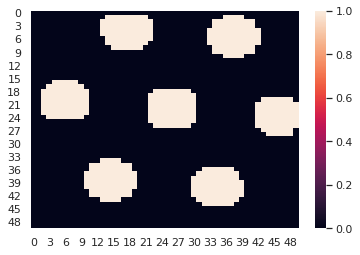

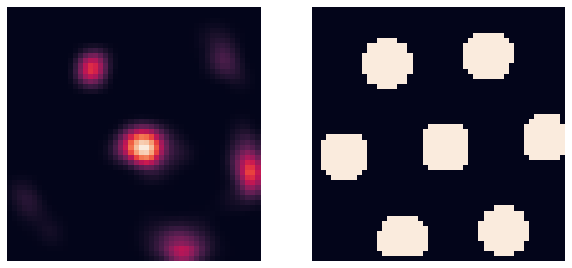

In [54]:
f,ax = plt.subplots(1,2, figsize=(10,5))
sns.heatmap(fr_map,xticklabels=False, yticklabels=False, cbar=False, square=True, ax=ax[0])
ax[0].invert_yaxis()

sns.heatmap(np.sum(grid_fields,axis=0), xticklabels=False, yticklabels=False, cbar=False, square=True, ax=ax[1])
ax[1].invert_yaxis()


fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/misc_figs/')
f.savefig(fig_path/'grid+moire_fields', bbox_inches='tight')

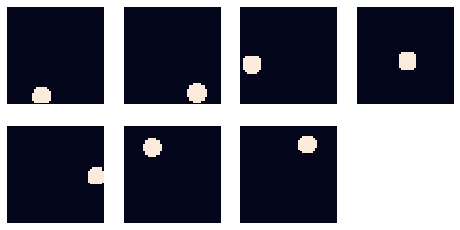

In [62]:
f,ax = plt.subplots(2,4, figsize=(8,4))
ax= ax.flatten()

n_fields = grid_fields.shape[0]

for ii in range(n_fields): 
    sns.heatmap(grid_fields[ii],xticklabels=False, yticklabels=False, cbar=False, square=True, ax=ax[ii])
    ax[ii].invert_yaxis()

ax[7].set_visible(False)

f.savefig(fig_path/'grid+moire_individual-fields', bbox_inches='tight')